In [142]:
import warnings
warnings.filterwarnings('ignore')

path = "../../kaggle/data/"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

### **Charegement des Datasets**

In [143]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
holiday_events = pd.read_csv(path + "holidays_events.csv")
oil = pd.read_csv(path + "oil.csv")
stores = pd.read_csv(path + "stores.csv")
transactions = pd.read_csv(path + "transactions.csv")

train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
holiday_events["date"] = pd.to_datetime(holiday_events.date)
oil["date"] = pd.to_datetime(oil.date)
transactions["date"] = pd.to_datetime(transactions.date)

### **Fusion de Train & Test**

In [44]:
train.head(1)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0


In [144]:
reordred_columns = list(train.drop('sales', axis=1).columns) + ['sales']
train2 = train[reordred_columns]
train2.head(2)

,id,date,store_nbr,family,onpromotion,sales
0,0,2013-01-01,1,AUTOMOTIVE,0,0.0
1,1,2013-01-01,1,BABY CARE,0,0.0


In [145]:
# Ajout de la variable sales et le remplir en nan
test['sales'] = np.nan
test.head(2)

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN
1,3000889,2017-08-16,1,BABY CARE,0,NaN


In [146]:
# conncaténation des deux dataset train et test
train_merged = pd.concat([train2, test])
train_merged.index = train_merged.id
train_merged.drop('id', axis=1, inplace=True)
train_merged

,date,store_nbr,family,onpromotion,sales
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0,0.0
1,2013-01-01,1,BABY CARE,0,0.0
2,2013-01-01,1,BEAUTY,0,0.0
3,2013-01-01,1,BEVERAGES,0,0.0
4,2013-01-01,1,BOOKS,0,0.0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,NaN
3029396,2017-08-31,9,PREPARED FOODS,0,NaN
3029397,2017-08-31,9,PRODUCE,1,NaN


In [147]:
print(f"Shape {train_merged.shape}")
print()
train_merged.head(2)

Shape (3029400, 5)



,date,store_nbr,family,onpromotion,sales
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0,0.0
1,2013-01-01,1,BABY CARE,0,0.0


### **Fusion avec stores**

In [148]:
train_merged = pd.merge(train_merged,
                        stores,
                        how = "left",
                        on = "store_nbr")

print(f"shape {train_merged.shape}")
print()
train_merged.head(2)

shape (3029400, 9)



,date,store_nbr,family,onpromotion,sales,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0,0.0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0,0.0,Quito,Pichincha,D,13


### **Fusion avec holiday_events**

In [149]:
train_merged = pd.merge(train_merged,
                        holiday_events.drop_duplicates(subset = ['date'], keep='last') ,
                        how = "left",
                        on = 'date', 
                        validate = "many_to_one", suffixes=("stores", "holiday"))

print(f"shape {train_merged.shape}")

shape (3029400, 14)


In [150]:
# convert transfered holidays to normal days (NDay)
train_merged["typeholiday"] = np.where(train_merged["transferred"]==True,'NDay',train_merged["typeholiday"])
train_merged["typeholiday"] = np.where(train_merged["typeholiday"]=='Work Day','NDay',train_merged["typeholiday"])
train_merged["typeholiday"] = train_merged["typeholiday"].fillna("NDay")

In [151]:
display(train_merged["typeholiday"].value_counts(dropna=False))

typeholiday
NDay          2603502
Holiday        249480
Event           98010
Additional      58806
Transfer        16038
Bridge           3564
Name: count, dtype: int64

### **Fusion avec oil**

In [152]:
train_merged = pd.merge(train_merged, oil, how = "left", on = 'date')
print(f"shape {train_merged.shape}")

shape (3029400, 15)


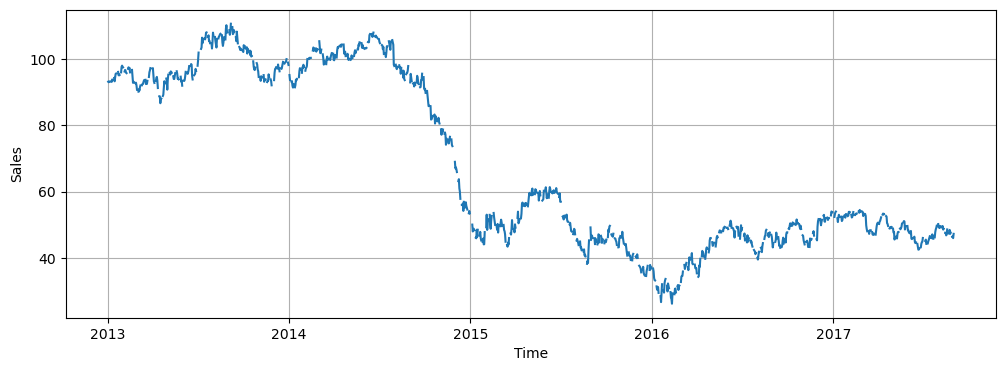

In [153]:
# plot oil
def plot_oil(data):
    fig, ax = plt.subplots(figsize=(12,4))
    plt.plot(data["date"], data["dcoilwtico"], '-')
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.show()
    plt.close()

plot_oil(train_merged)

In [154]:
# avant remplissage des valeurs manquantes
train_merged[['dcoilwtico']].isna().sum()

dcoilwtico    935550
dtype: int64

In [155]:
# interpolation lineaire pour remplir les valeurs à O et les valeurs manquantes 
train_merged["dcoilwtico"] = np.where(train_merged["dcoilwtico"] == 0, np.nan, train_merged["dcoilwtico"])
train_merged.dcoilwtico.interpolate(limit_direction='both',inplace=True)

In [156]:
# après remplissage des valeurs manquantes
train_merged[['dcoilwtico']].isna().sum()

dcoilwtico    0
dtype: int64

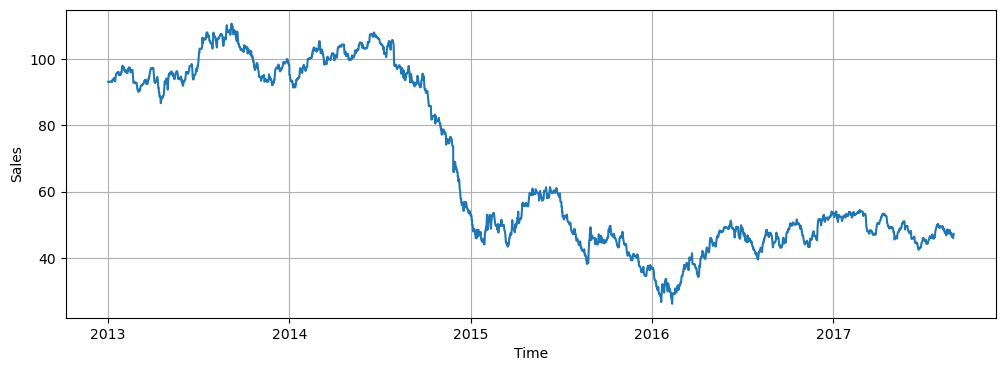

In [157]:
plot_oil(train_merged)

### **Numérisatoin de la variable date**

In [158]:
# extracting time features for train dataset
train_merged['day_of_week'] = train_merged['date'].dt.day_of_week
train_merged['day_of_week'] = train_merged['day_of_week']+1
train_merged['month'] = train_merged['date'].dt.month
train_merged['year'] = train_merged['date'].dt.year

In [159]:
train_merged.isna().sum()

date                 0
store_nbr            0
family               0
onpromotion          0
sales            28512
city                 0
state                0
typestores           0
cluster              0
typeholiday          0
locale         2578554
locale_name    2578554
description    2578554
transferred    2578554
dcoilwtico           0
day_of_week          0
month                0
year                 0
dtype: int64

### **Export de Dataset prétraité**

In [160]:
train_merged.to_csv(path + "train_merged.csv", index=False, header=True, sep=',')